# Imports

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import floor
from scipy.stats import norm
import warnings

# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# High Frequency Data

In [126]:
df_message = pd.read_csv("HF_Data/LOBSTER_SampleFile_MSFT_2012-06-21_50/MSFT_2012-06-21_34200000_37800000_message_50.csv")
df_message.head()

,34200.01399412,3,16085616,100,310400,-1
0,34200.013994,1,16116348,100,310500,-1
1,34200.015248,1,16116658,100,310400,-1
2,34200.015442,1,16116704,100,310500,-1
3,34200.015789,1,16116752,100,310600,-1
4,34200.016300,1,16116815,100,310700,-1


In [127]:
# Renommer les colonnes de df_messages selon la spécification
rename_mapping = {
    df_message.columns[0]: "Time",        # Seconds after midnight (float, ms à ns)
    df_message.columns[1]: "Type",        # Type d'événement (1,2,3,4,5,7)
    df_message.columns[2]: "OrderID",     # Identifiant unique de l'ordre
    df_message.columns[3]: "Size",        # Nombre d'actions
    df_message.columns[4]: "Price",       # Prix * 10 000
    df_message.columns[5]: "Direction"    # -1: Sell, 1: Buy
}

df_message = df_message.rename(columns=rename_mapping)

# Vérification
print(df_message.head())
print("\nColonnes renommées :", df_message.columns.tolist())

           Time  Type   OrderID  Size   Price  Direction
0  34200.013994     1  16116348   100  310500         -1
1  34200.015248     1  16116658   100  310400         -1
2  34200.015442     1  16116704   100  310500         -1
3  34200.015789     1  16116752   100  310600         -1
4  34200.016300     1  16116815   100  310700         -1

Colonnes renommées : ['Time', 'Type', 'OrderID', 'Size', 'Price', 'Direction']


In [128]:
df_OB  = pd.read_csv("HF_Data/LOBSTER_SampleFile_MSFT_2012-06-21_50/MSFT_2012-06-21_34200000_37800000_orderbook_50.csv")
df_OB.head()

,309900,3788,309500,300,310500,100,309300,3986,310600,100.1,...,-9999999999.7,0.20,9999999999.13,0.21,-9999999999.8,0.22,9999999999.14,0.23,-9999999999.9,0.24
0,309900,3788,309500,300,310500,200,309300,3986,310600,100,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0
1,309900,3788,309500,300,310400,100,309300,3986,310500,200,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0
2,309900,3788,309500,300,310400,100,309300,3986,310500,300,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0
3,309900,3788,309500,300,310400,100,309300,3986,310500,300,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0
4,309900,3788,309500,300,310400,100,309300,3986,310500,300,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0


In [129]:
num_levels = 50

new_columns = []
for level in range(1, num_levels + 1):
    new_columns += [
        f"AskPrice_{level}",  # Prix Ask du niveau i
        f"AskSize_{level}",   # Volume Ask du niveau i
        f"BidPrice_{level}",  # Prix Bid du niveau i
        f"BidSize_{level}",   # Volume Bid du niveau i
    ]

if len(df_OB.columns) != len(new_columns):
    raise ValueError(
        f"Le DataFrame df_OB contient {len(df_OB.columns)} colonnes, "
        f"mais {len(new_columns)} étaient attendues pour {num_levels} niveaux."
    )

df_OB.columns = new_columns

print(df_OB.columns[:8])  # affiche les premières colonnes pour vérif
print(f"\nTotal colonnes renommées : {len(df_OB.columns)}")


Index(['AskPrice_1', 'AskSize_1', 'BidPrice_1', 'BidSize_1', 'AskPrice_2',
       'AskSize_2', 'BidPrice_2', 'BidSize_2'],
      dtype='object')

Total colonnes renommées : 200


In [130]:
# Convertir les prix (divisés par 10000)
df_message['Price'] = df_message['Price'] / 10000
df_OB['AskPrice_1'] = df_OB['AskPrice_1'] / 10000
df_OB['BidPrice_1'] = df_OB['BidPrice_1'] / 10000

# Remplacer les valeurs dummy par NaN
df_OB['AskPrice_1'] = df_OB['AskPrice_1'].replace(999999.9999, np.nan)
df_OB['BidPrice_1'] = df_OB['BidPrice_1'].replace(-999999.9999, np.nan)

# Calculer le mid-price et le spread
df_OB['MidPrice'] = (df_OB['AskPrice_1'] + df_OB['BidPrice_1']) / 2
df_OB['Spread'] = df_OB['AskPrice_1'] - df_OB['BidPrice_1']

# Ajouter le timestamp et définir comme index
df_OB['Time'] = df_message['Time'].values
df_OB = df_OB.set_index('Time')

# Supprimer les NaN
df_OB = df_OB.dropna(subset=['MidPrice', 'Spread'])

print("=" * 60)
print("STATISTIQUES DESCRIPTIVES")
print("=" * 60)
print(f"Nombre d'observations: {len(df_OB):,}")
print(f"Spread moyen: ${df_OB['Spread'].mean():.6f}")
print(f"Spread médian: ${df_OB['Spread'].median():.6f}")
print(f"Spread min: ${df_OB['Spread'].min():.6f}")
print(f"Spread max: ${df_OB['Spread'].max():.6f}")
print(f"Prix moyen: ${df_OB['MidPrice'].mean():.2f}")
print(f"Prix min: ${df_OB['MidPrice'].min():.2f}")
print(f"Prix max: ${df_OB['MidPrice'].max():.2f}")

STATISTIQUES DESCRIPTIVES
Nombre d'observations: 141,506
Spread moyen: $0.013281
Spread médian: $0.010000
Spread min: $0.010000
Spread max: $0.050000
Prix moyen: $30.89
Prix min: $30.66
Prix max: $31.14


In [131]:
print(df_OB.shape)
print(df_OB.columns)
print(df_OB['MidPrice'].head())
print(df_OB.index[:5])

(141506, 202)
Index(['AskPrice_1', 'AskSize_1', 'BidPrice_1', 'BidSize_1', 'AskPrice_2',
       'AskSize_2', 'BidPrice_2', 'BidSize_2', 'AskPrice_3', 'AskSize_3',
       ...
       'AskPrice_49', 'AskSize_49', 'BidPrice_49', 'BidSize_49', 'AskPrice_50',
       'AskSize_50', 'BidPrice_50', 'BidSize_50', 'MidPrice', 'Spread'],
      dtype='object', length=202)
Time
34200.013994    30.97
34200.015248    30.97
34200.015442    30.97
34200.015789    30.97
34200.016300    30.97
Name: MidPrice, dtype: float64
Index([ 34200.01399412, 34200.015247805, 34200.015442111, 34200.015789148,
       34200.016299574],
      dtype='float64', name='Time')


In [132]:
print(df_OB.index.name)

Time


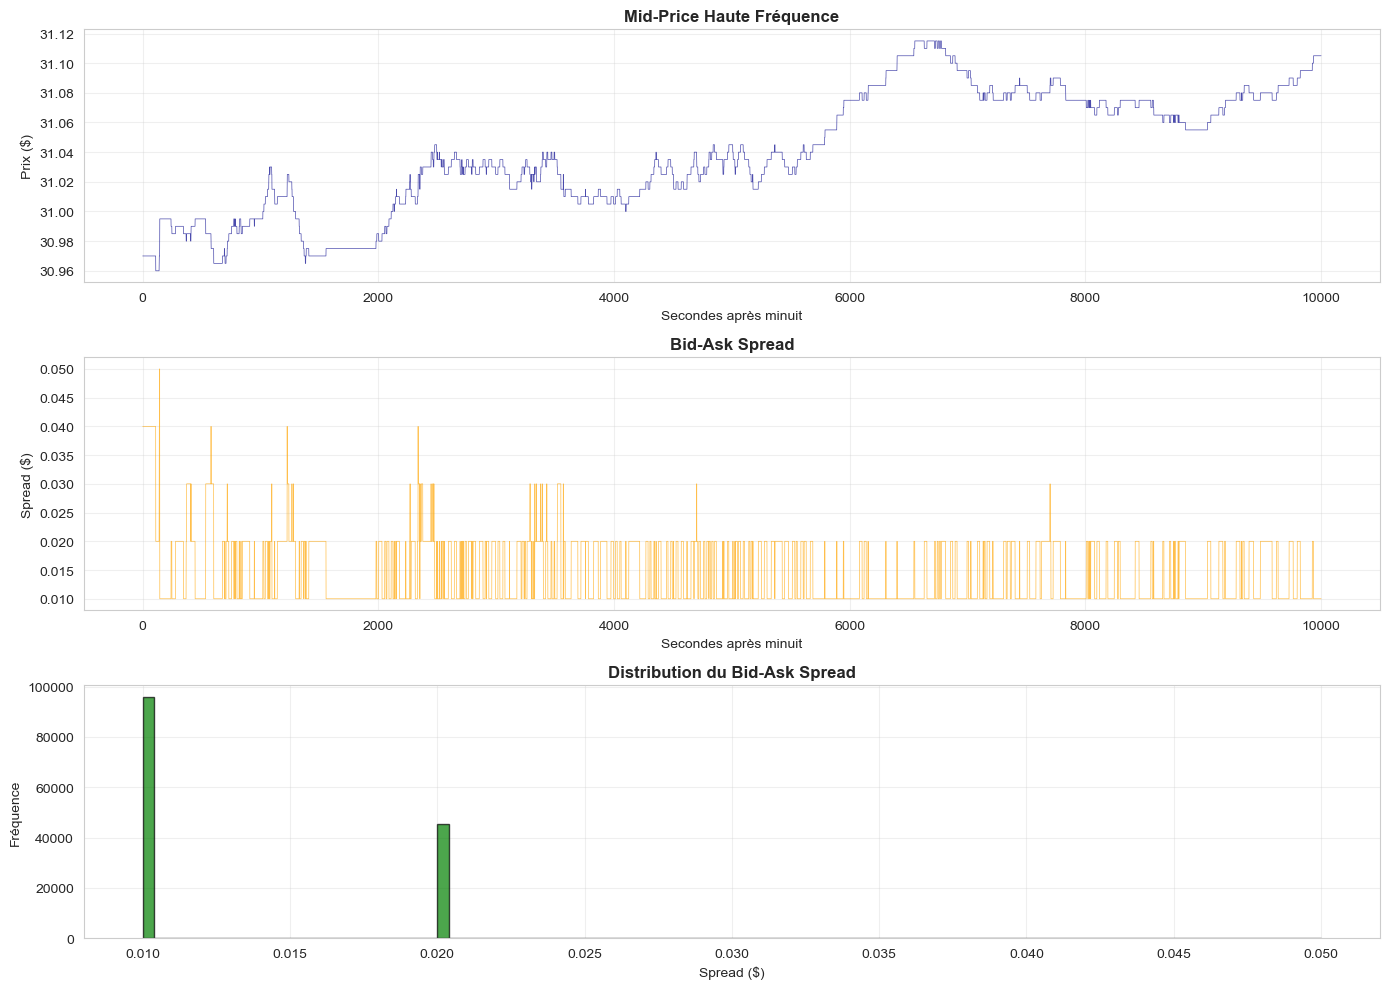

In [133]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Limiter à 10000 observations pour la visualisation
n_viz = min(10000, len(df_OB))

df_OB = df_OB.reset_index()  # remet Time en colonne

# Prix mid-price haute fréquence
axes[0].plot(df_OB.index[:n_viz], df_OB['MidPrice'][:n_viz], 
             linewidth=0.5, color='darkblue', alpha=0.7)
axes[0].set_title('Mid-Price Haute Fréquence', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Secondes après minuit')
axes[0].set_ylabel('Prix ($)')
axes[0].grid(True, alpha=0.3)

# Spread bid-ask
axes[1].plot(df_OB.index[:n_viz], df_OB['Spread'][:n_viz], 
             color='orange', linewidth=0.5, alpha=0.7)
axes[1].set_title('Bid-Ask Spread', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Secondes après minuit')
axes[1].set_ylabel('Spread ($)')
axes[1].grid(True, alpha=0.3)

# Distribution du spread
axes[2].hist(df_OB['Spread'], bins=100, color='green', alpha=0.7, edgecolor='black')
axes[2].set_title('Distribution du Bid-Ask Spread', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Spread ($)')
axes[2].set_ylabel('Fréquence')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('1_price_exploration.png', dpi=300, bbox_inches='tight')
plt.show()

In [157]:
def compute_returns(prices, freq_seconds=1):
    """
    Calcule les rendements log à une fréquence donnée
    
    Args:
        prices: Series avec index temporel
        freq_seconds: Fréquence d'échantillonnage en secondes
    
    Returns:
        Series de rendements log
    """
    # Resample à la fréquence voulue (prendre le dernier prix)
    prices_resampled = prices.resample(f'{freq_seconds}S').last().dropna()
    
    # Rendements log
    returns = np.log(prices_resampled / prices_resampled.shift(1)).dropna()
    
    return returns

# Calculer rendements à différentes fréquences
frequencies = [1, 5, 10, 30, 60, 120, 300, 600]  # en secondes
returns_dict = {}

print("=" * 60)
print("CALCUL DES RENDEMENTS")
print("=" * 60)

if not isinstance(df_OB.index, pd.TimedeltaIndex):
    df_OB = df_OB.set_index(pd.to_timedelta(df_OB['Time'], unit='s'))
    df_OB.index.name = 'Time'

for freq in frequencies:
    returns_dict[freq] = compute_returns(df_OB['MidPrice'], freq)
    print(f"Freq {freq:3d}s: {len(returns_dict[freq]):6,} observations, "
          f"std = {returns_dict[freq].std():.8f}")

CALCUL DES RENDEMENTS
Freq   1s:  3,398 observations, std = 0.00013426
Freq   5s:    719 observations, std = 0.00028929
Freq  10s:    359 observations, std = 0.00042340
Freq  30s:    119 observations, std = 0.00068206
Freq  60s:     59 observations, std = 0.00089018
Freq 120s:     29 observations, std = 0.00135677
Freq 300s:     11 observations, std = 0.00272306
Freq 600s:      5 observations, std = 0.00485552


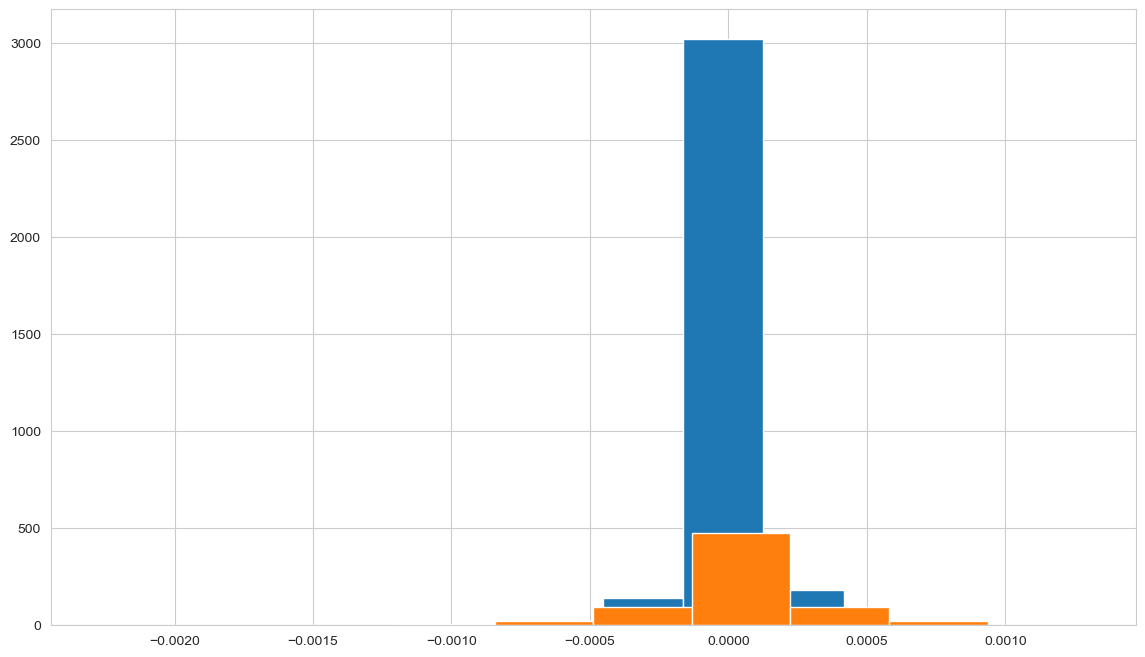

In [165]:
returns_dict[1].hist()
returns_dict[5].hist()
plt.show()

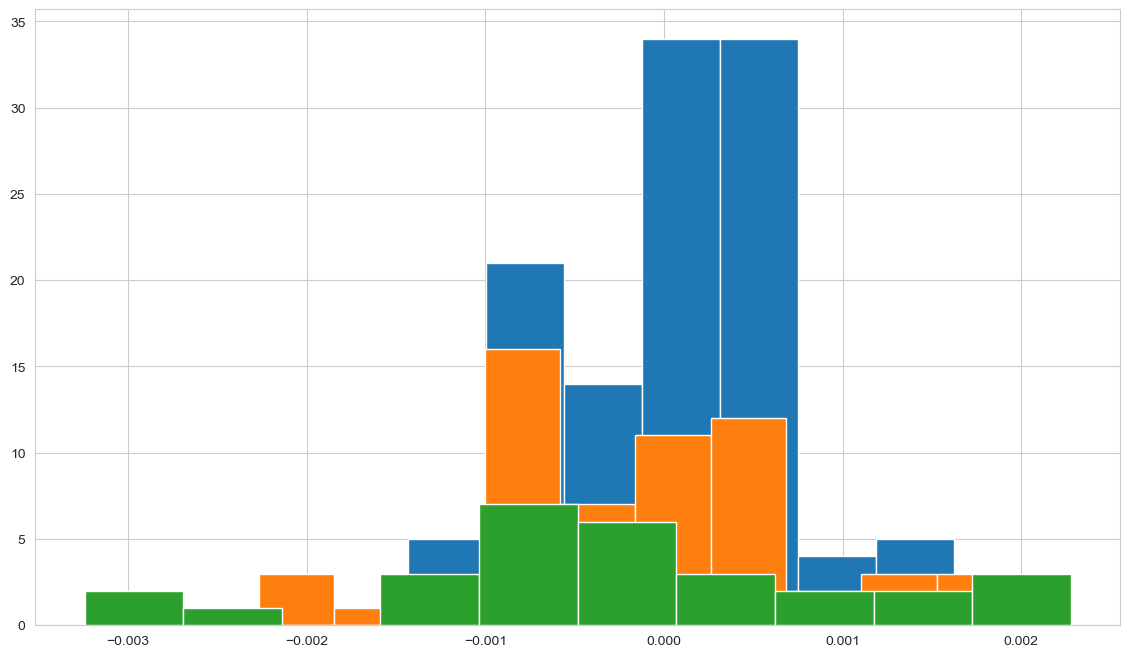

In [167]:
returns_dict[30].hist()
returns_dict[60].hist()
returns_dict[120].hist()
plt.show()

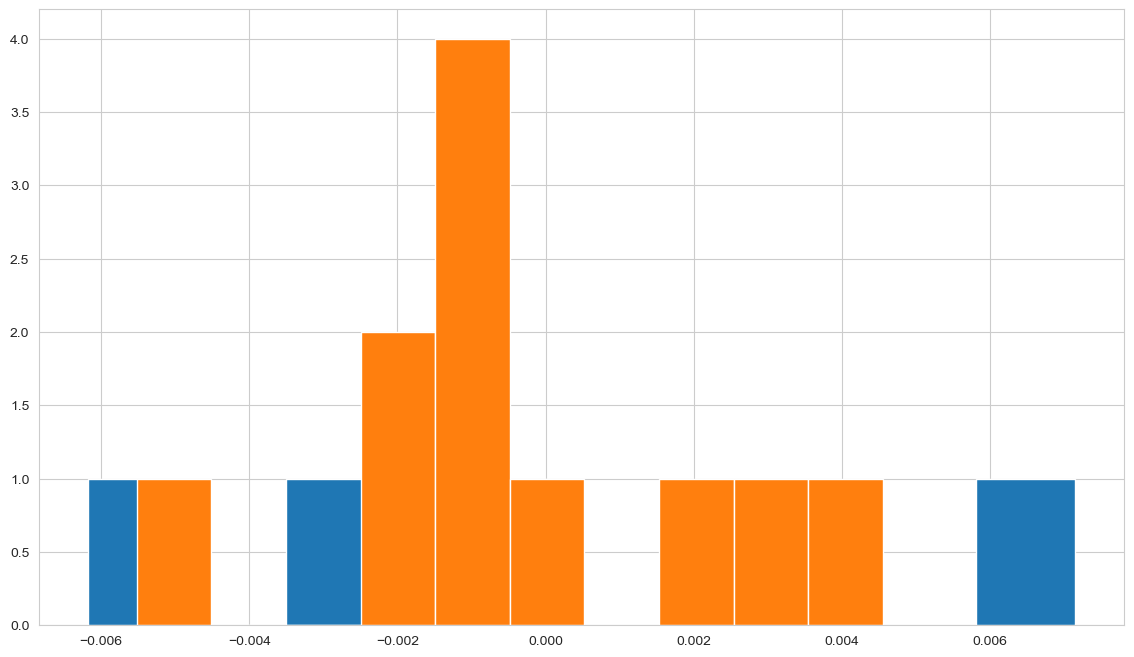

In [169]:
returns_dict[600].hist()
returns_dict[300].hist()
plt.show()

In [135]:
def realized_volatility(returns):
    """
    Calcule la volatilité réalisée (somme des rendements carrés)
    Annualisée avec sqrt(252) pour les jours de trading
    """
    rv_daily = np.sqrt(np.sum(returns**2))
    return rv_daily

# Calculer RV pour chaque fréquence
rv_results = {}

print("\n" + "=" * 60)
print("VOLATILITÉ RÉALISÉE PAR FRÉQUENCE")
print("=" * 60)

for freq, rets in returns_dict.items():
    rv_results[freq] = realized_volatility(rets)
    print(f"RV (freq={freq:3d}s): {rv_results[freq]:.8f}")

# Ratio RV haute fréquence / basse fréquence
rv_ratio = rv_results[1] / rv_results[300]
print(f"\n{'='*60}")
print(f"Ratio RV(1s) / RV(300s) = {rv_ratio:.4f}")
print(f"{'='*60}")
if rv_ratio > 1.2:
    print("BRUIT SIGNIFICATIF: La RV augmente aux hautes fréquences")
else:
    print("Bruit limité")


VOLATILITÉ RÉALISÉE PAR FRÉQUENCE
RV (freq=  1s): 0.00782582
RV (freq=  5s): 0.00775416
RV (freq= 10s): 0.00801424
RV (freq= 30s): 0.00742929
RV (freq= 60s): 0.00682400
RV (freq=120s): 0.00731068
RV (freq=300s): 0.00875122
RV (freq=600s): 0.00979806

Ratio RV(1s) / RV(300s) = 0.8943
Bruit limité


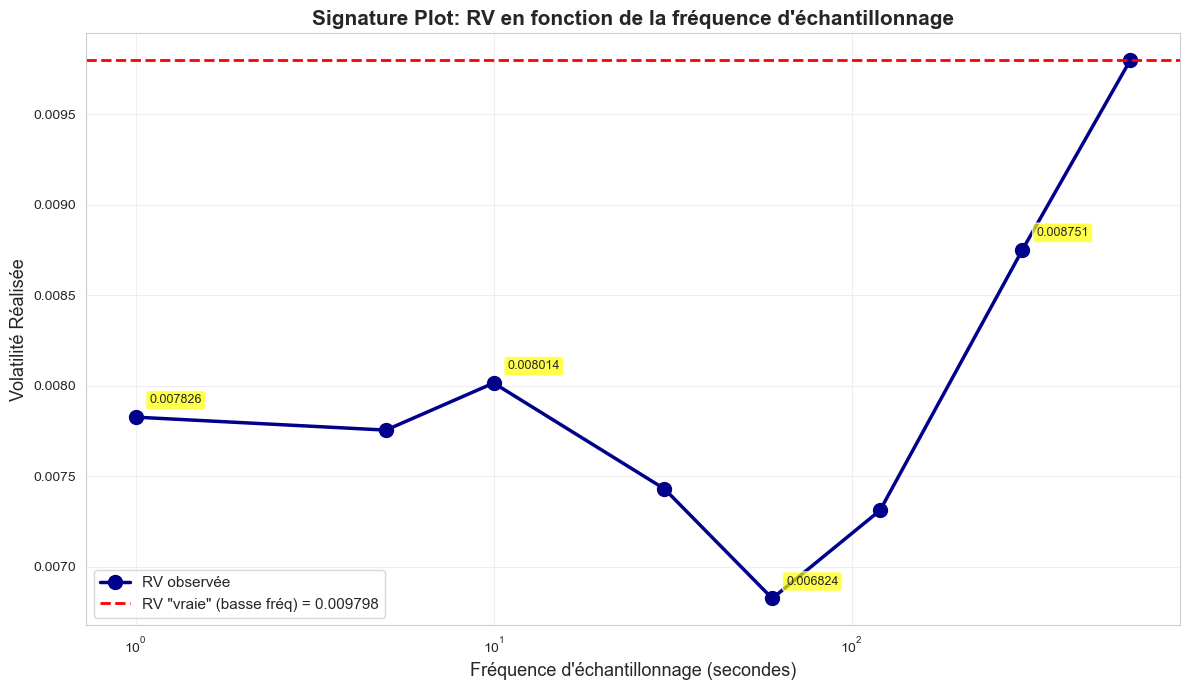


INTERPRÉTATION DU SIGNATURE PLOT
Si la RV augmente quand la fréquence augmente (valeur basse en secondes),
cela indique la présence de BRUIT DE MICROSTRUCTURE.

Ratio RV(1s) / RV(300s) = 0.894
→ Ratio acceptable, bruit limité


In [136]:
plt.figure(figsize=(12, 7))

freqs = list(rv_results.keys())
rvs = list(rv_results.values())

plt.plot(freqs, rvs, marker='o', markersize=10, linewidth=2.5, 
         color='darkblue', label='RV observée')
plt.axhline(y=rvs[-1], color='red', linestyle='--', linewidth=2,
            label=f'RV "vraie" (basse fréq) = {rvs[-1]:.6f}')

plt.xlabel('Fréquence d\'échantillonnage (secondes)', fontsize=13)
plt.ylabel('Volatilité Réalisée', fontsize=13)
plt.title('Signature Plot: RV en fonction de la fréquence d\'échantillonnage', 
          fontsize=15, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.xscale('log')

# Annotations
for i, (f, rv) in enumerate(zip(freqs, rvs)):
    if i % 2 == 0:  # Annoter seulement certains points
        plt.annotate(f'{rv:.6f}', 
                    xy=(f, rv), 
                    xytext=(10, 10),
                    textcoords='offset points',
                    fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.savefig('2_signature_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)
print("INTERPRÉTATION DU SIGNATURE PLOT")
print("=" * 60)
print("Si la RV augmente quand la fréquence augmente (valeur basse en secondes),")
print("cela indique la présence de BRUIT DE MICROSTRUCTURE.")
print(f"\nRatio RV(1s) / RV(300s) = {rv_ratio:.3f}")
if rv_ratio > 1.2:
    print("→ Un ratio > 1.2 suggère un bruit SIGNIFICATIF")
else:
    print("→ Ratio acceptable, bruit limité")

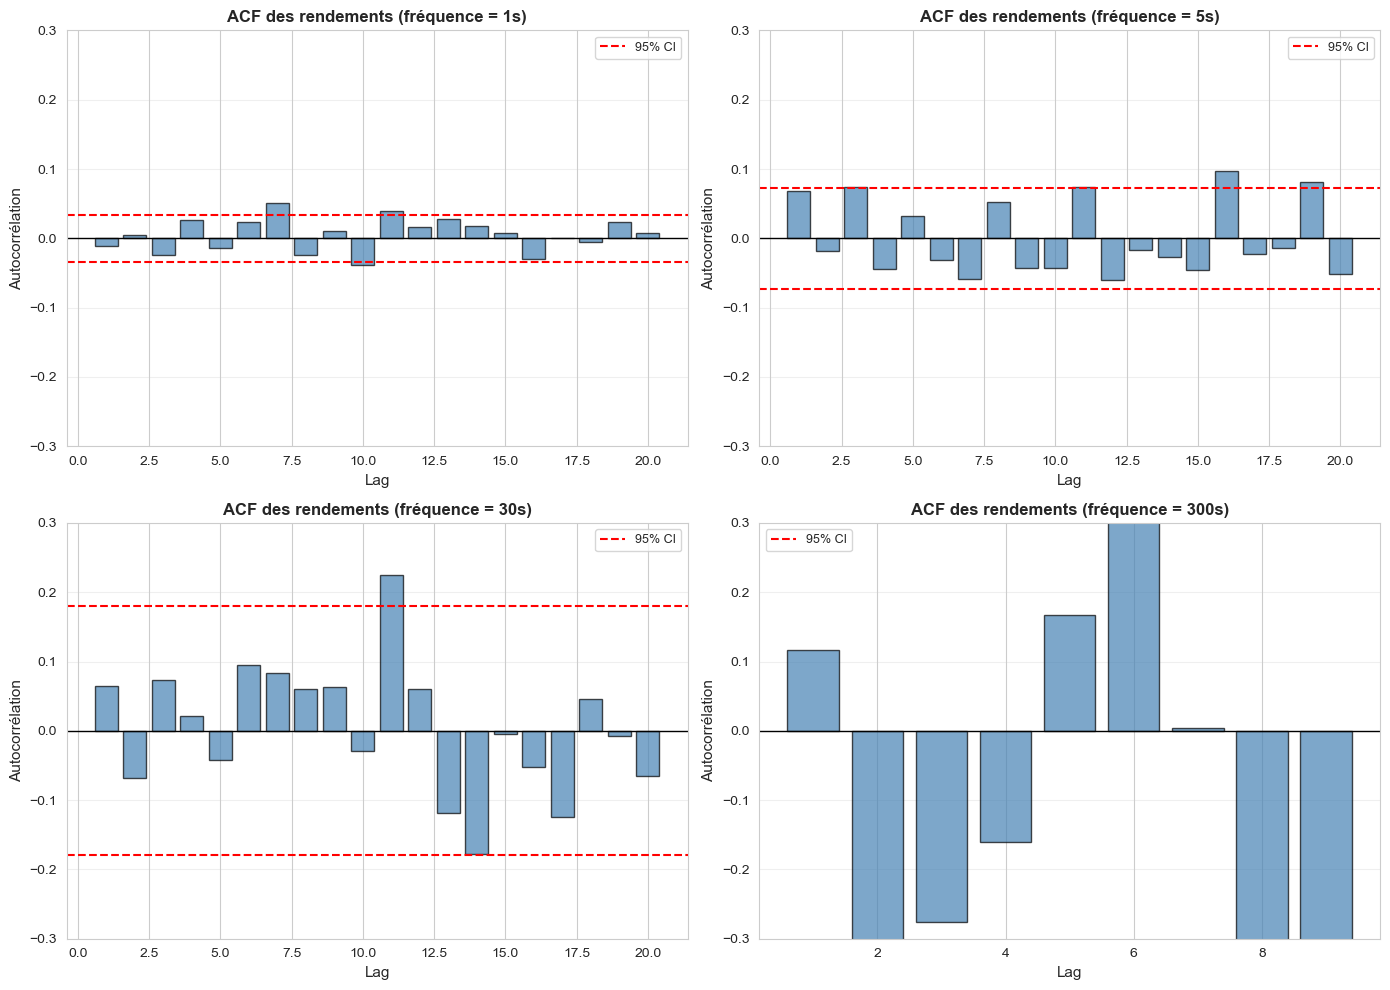


INTERPRÉTATION DE L'AUTOCORRÉLATION
Une autocorrélation NÉGATIVE au lag 1 pour les hautes fréquences
est un signe classique de BID-ASK BOUNCE (bruit de microstructure).

Résultats ACF(1):
------------------------------------------------------------
  ACF(1) à   1s: -0.011206 
  ACF(1) à   5s: +0.067685 
  ACF(1) à  30s: +0.064926 
  ACF(1) à 300s: +0.116918 

*** = Significativement différent de 0 au seuil 5%


In [137]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

test_freqs = [1, 5, 30, 300]

for i, freq in enumerate(test_freqs):
    ax = axes[i // 2, i % 2]
    rets = returns_dict[freq]
    
    # Calculer autocorrélation pour les 20 premiers lags
    max_lag = 20
    acf_vals = [rets.autocorr(lag=lag) for lag in range(1, max_lag + 1)]
    
    # Barre plot
    ax.bar(range(1, max_lag + 1), acf_vals, color='steelblue', alpha=0.7, edgecolor='black')
    ax.axhline(y=0, color='black', linewidth=1)
    
    # Intervalle de confiance à 95%
    conf_interval = 1.96 / np.sqrt(len(rets))
    ax.axhline(y=conf_interval, color='red', linestyle='--', linewidth=1.5, 
               label='95% CI')
    ax.axhline(y=-conf_interval, color='red', linestyle='--', linewidth=1.5)
    
    ax.set_xlabel('Lag', fontsize=11)
    ax.set_ylabel('Autocorrélation', fontsize=11)
    ax.set_title(f'ACF des rendements (fréquence = {freq}s)', fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(fontsize=9)
    ax.set_ylim(-0.3, 0.3)

plt.tight_layout()
plt.savefig('3_autocorrelation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)
print("INTERPRÉTATION DE L'AUTOCORRÉLATION")
print("=" * 60)
print("Une autocorrélation NÉGATIVE au lag 1 pour les hautes fréquences")
print("est un signe classique de BID-ASK BOUNCE (bruit de microstructure).")
print("\nRésultats ACF(1):")
print("-" * 60)

for freq in test_freqs:
    lag1_acf = returns_dict[freq].autocorr(lag=1)
    significant = abs(lag1_acf) > 1.96 / np.sqrt(len(returns_dict[freq]))
    sig_marker = "***" if significant else ""
    print(f"  ACF(1) à {freq:3d}s: {lag1_acf:+.6f} {sig_marker}")
    
print("\n*** = Significativement différent de 0 au seuil 5%")

In [138]:
def variance_ratio(returns, q=2):
    """
    Calcule le variance ratio pour tester la présence de bruit
    VR(q) = Var(r_t + ... + r_{t-q+1}) / (q * Var(r_t))
    
    Sous l'hypothèse nulle (pas de bruit): VR(q) ≈ 1
    Avec bruit de microstructure: VR(q) < 1
    """
    n = len(returns)
    
    # Variance des rendements simples
    var_1 = returns.var()
    
    # Variance des rendements agrégés sur q périodes
    returns_q = returns.rolling(window=q).sum().dropna()
    var_q = returns_q.var()
    
    # Variance ratio
    vr = var_q / (q * var_1)
    
    return vr

print("\n" + "=" * 60)
print("VARIANCE RATIO TEST")
print("=" * 60)
print("VR(q) ≈ 1 → Pas de bruit")
print("VR(q) < 1 → Présence de bruit de microstructure")
print("-" * 60)

for freq in [1, 5, 30, 300]:
    rets = returns_dict[freq]
    vr2 = variance_ratio(rets, q=2)
    vr5 = variance_ratio(rets, q=5)
    vr10 = variance_ratio(rets, q=10)
    
    print(f"\nFréquence {freq}s:")
    print(f"  VR(2)  = {vr2:.4f}")
    print(f"  VR(5)  = {vr5:.4f}")
    print(f"  VR(10) = {vr10:.4f}")
    
    if vr2 < 0.9:
        print(f"VR(2) < 0.9 suggère un BRUIT SIGNIFICATIF ")
    elif vr2 > 1.1:
        print(f"VR(2) > 1.1 suggère une possible autocorrélation positive")
    else:
        print(f"VR proche de 1, bruit limité")


VARIANCE RATIO TEST
VR(q) ≈ 1 → Pas de bruit
VR(q) < 1 → Présence de bruit de microstructure
------------------------------------------------------------

Fréquence 1s:
  VR(2)  = 0.9889
  VR(5)  = 0.9782
  VR(10) = 1.0093
VR proche de 1, bruit limité

Fréquence 5s:
  VR(2)  = 1.0580
  VR(5)  = 1.1243
  VR(10) = 1.1311
VR proche de 1, bruit limité

Fréquence 30s:
  VR(2)  = 1.0733
  VR(5)  = 1.1040
  VR(10) = 1.3104
VR proche de 1, bruit limité

Fréquence 300s:
  VR(2)  = 1.2052
  VR(5)  = 0.5900
  VR(10) = 0.0063
VR(2) > 1.1 suggère une possible autocorrélation positive


In [139]:
def estimate_noise_variance(returns_hf, returns_lf):
    """
    Estime la variance du bruit de microstructure
    
    Sous le modèle simple: 
    P_observed = P_efficient + noise
    
    On a approximativement:
    Var(r_hf) ≈ Var(r_efficient) + 2*Var(noise)/Δt_hf
    Var(r_lf) ≈ Var(r_efficient) + 2*Var(noise)/Δt_lf
    
    Si Δt_lf >> Δt_hf, alors Var(r_lf) ≈ Var(r_efficient)
    
    Donc: Var(noise) ≈ (Var(r_hf) - Var(r_lf)) / 2 * Δt_hf
    """
    var_hf = returns_hf.var()
    var_lf = returns_lf.var()
    
    # Approximation simple (suppose que le terme de bruit domine en HF)
    noise_var = max(0, (var_hf - var_lf) / 2)
    
    return noise_var, var_lf

# Estimer le bruit en comparant 1s vs 300s
noise_var, signal_var = estimate_noise_variance(returns_dict[1], returns_dict[300])

# Signal-to-noise ratio
if noise_var > 0:
    snr = signal_var / noise_var
else:
    snr = np.inf

print("\n" + "=" * 60)
print("ESTIMATION DU BRUIT DE MICROSTRUCTURE")
print("=" * 60)
print(f"Variance du bruit (estimée):    {noise_var:.10f}")
print(f"Variance du signal (300s):      {signal_var:.10f}")
print(f"Signal-to-Noise Ratio (SNR):    {snr:.2f}")
print("-" * 60)

if snr < 10:
    print("⚠️  SNR < 10: Le bruit est TRÈS significatif")
    print("   → Estimateurs robustes INDISPENSABLES")
elif snr < 50:
    print("⚠️  SNR < 50: Bruit modéré mais non négligeable")
    print("   → Estimateurs robustes RECOMMANDÉS")
else:
    print("✓ SNR élevé: Bruit limité")
    print("   → RV classique acceptable")

# Calculer l'écart-type du bruit en prix
noise_std_price = np.sqrt(noise_var) * df_OB['MidPrice'].mean()
print(f"\nÉcart-type du bruit (en $):     ${noise_std_price:.6f}")
print(f"En % du prix:                   {noise_std_price/df_OB['MidPrice'].mean()*100:.4f}%")
print(f"Spread moyen:                   ${df_OB['Spread'].mean():.6f}")


ESTIMATION DU BRUIT DE MICROSTRUCTURE
Variance du bruit (estimée):    0.0000000000
Variance du signal (300s):      0.0000074150
Signal-to-Noise Ratio (SNR):    inf
------------------------------------------------------------
✓ SNR élevé: Bruit limité
   → RV classique acceptable

Écart-type du bruit (en $):     $0.000000
En % du prix:                   0.0000%
Spread moyen:                   $0.013281


In [140]:
print("\n" + "=" * 80)
print(" " * 20 + "RÉSUMÉ DES DIAGNOSTICS DE BRUIT")
print("=" * 80)

diagnostics = []
scores = []

# Test 1: Signature plot
rv_ratio = rv_results[1] / rv_results[300]
if rv_ratio > 1.5:
    diagnostics.append(f"✓✓ Signature plot: RV ratio = {rv_ratio:.3f} → BRUIT TRÈS SIGNIFICATIF")
    scores.append(2)
elif rv_ratio > 1.2:
    diagnostics.append(f"✓ Signature plot: RV ratio = {rv_ratio:.3f} → BRUIT DÉTECTÉ")
    scores.append(1)
else:
    diagnostics.append(f"✗ Signature plot: RV ratio = {rv_ratio:.3f} → Bruit limité")
    scores.append(0)

# Test 2: Autocorrélation
lag1_acf_1s = returns_dict[1].autocorr(lag=1)
if lag1_acf_1s < -0.10:
    diagnostics.append(f"✓✓ Autocorrélation: ACF(1) = {lag1_acf_1s:.4f} → BID-ASK BOUNCE FORT")
    scores.append(2)
elif lag1_acf_1s < -0.05:
    diagnostics.append(f"✓ Autocorrélation: ACF(1) = {lag1_acf_1s:.4f} → BID-ASK BOUNCE DÉTECTÉ")
    scores.append(1)
else:
    diagnostics.append(f"✗ Autocorrélation: ACF(1) = {lag1_acf_1s:.4f} → Bruit limité")
    scores.append(0)

# Test 3: Variance ratio
vr2_1s = variance_ratio(returns_dict[1], q=2)
if vr2_1s < 0.85:
    diagnostics.append(f"✓✓ Variance Ratio: VR(2) = {vr2_1s:.4f} → BRUIT TRÈS SIGNIFICATIF")
    scores.append(2)
elif vr2_1s < 0.95:
    diagnostics.append(f"✓ Variance Ratio: VR(2) = {vr2_1s:.4f} → BRUIT DÉTECTÉ")
    scores.append(1)
else:
    diagnostics.append(f"✗ Variance Ratio: VR(2) = {vr2_1s:.4f} → Bruit limité")
    scores.append(0)

# Test 4: Signal-to-Noise Ratio
if snr < 10:
    diagnostics.append(f"✓✓ SNR: {snr:.2f} → BRUIT TRÈS SIGNIFICATIF")
    scores.append(2)
elif snr < 50:
    diagnostics.append(f"✓ SNR: {snr:.2f} → BRUIT MODÉRÉ")
    scores.append(1)
else:
    diagnostics.append(f"✗ SNR: {snr:.2f} → Bruit limité")
    scores.append(0)

for diag in diagnostics:
    print(f"\n{diag}")

total_score = sum(scores)
max_score = len(scores) * 2

print("\n" + "=" * 80)
print(f"SCORE TOTAL: {total_score}/{max_score}")
print("=" * 80)

if total_score >= 6:
    print("\n🚨 CONCLUSION: BRUIT DE MICROSTRUCTURE TRÈS SIGNIFICATIF")
    print("\n→ Il est ABSOLUMENT NÉCESSAIRE d'utiliser des estimateurs robustes:")
    print("   • Two-Scale Realized Volatility (TSRV)")
    print("   • Realized Kernel (Parzen, Bartlett)")
    print("   • Pre-averaging")
    print("\n→ La volatilité réalisée classique est BIAISÉE et ne doit PAS être utilisée")
elif total_score >= 3:
    print("\n⚠️  CONCLUSION: BRUIT DE MICROSTRUCTURE DÉTECTÉ")
    print("\n→ Il est FORTEMENT RECOMMANDÉ d'utiliser des estimateurs robustes")
    print("→ La volatilité réalisée classique sous-estime la vraie volatilité")
else:
    print("\n✓ CONCLUSION: Bruit de microstructure limité")
    print("\n→ La volatilité réalisée classique peut être utilisée")
    print("→ Mais des estimateurs robustes peuvent quand même améliorer la précision")


                    RÉSUMÉ DES DIAGNOSTICS DE BRUIT

✗ Signature plot: RV ratio = 0.894 → Bruit limité

✗ Autocorrélation: ACF(1) = -0.0112 → Bruit limité

✗ Variance Ratio: VR(2) = 0.9889 → Bruit limité

✗ SNR: inf → Bruit limité

SCORE TOTAL: 0/8

✓ CONCLUSION: Bruit de microstructure limité

→ La volatilité réalisée classique peut être utilisée
→ Mais des estimateurs robustes peuvent quand même améliorer la précision


In [141]:
results_df = pd.DataFrame({
    'Frequency_seconds': list(rv_results.keys()),
    'Realized_Volatility': list(rv_results.values()),
    'Num_observations': [len(returns_dict[f]) for f in rv_results.keys()],
    'ACF_lag1': [returns_dict[f].autocorr(1) for f in rv_results.keys()],
    'VR_2': [variance_ratio(returns_dict[f], 2) for f in rv_results.keys()],
    'VR_5': [variance_ratio(returns_dict[f], 5) for f in rv_results.keys()],
})

# Ajouter des colonnes supplémentaires
results_df['RV_ratio'] = results_df['Realized_Volatility'] / results_df['Realized_Volatility'].iloc[-1]
results_df['ACF_significant'] = abs(results_df['ACF_lag1']) > 1.96 / np.sqrt(results_df['Num_observations'])

# Afficher le tableau
print("\n" + "=" * 80)
print("TABLEAU RÉCAPITULATIF")
print("=" * 80)
print(results_df.to_string(index=False))

# Sauvegarder
results_df.to_csv('microstructure_diagnostics.csv', index=False)

print("\n" + "=" * 80)
print("FICHIERS GÉNÉRÉS")
print("=" * 80)
print("✓ 1_price_exploration.png")
print("✓ 2_signature_plot.png")
print("✓ 3_autocorrelation.png")
print("✓ microstructure_diagnostics.csv")
print("\n" + "=" * 80)


TABLEAU RÉCAPITULATIF
 Frequency_seconds  Realized_Volatility  Num_observations  ACF_lag1     VR_2     VR_5  RV_ratio  ACF_significant
                 1             0.007826              3398 -0.011206 0.988879 0.978165  0.798712            False
                 5             0.007754               719  0.067685 1.057956 1.124307  0.791397            False
                10             0.008014               359  0.049912 1.044153 1.066746  0.817941            False
                30             0.007429               119  0.064926 1.073263 1.104046  0.758241            False
                60             0.006824                59  0.119876 1.109033 1.503970  0.696464            False
               120             0.007311                29  0.212441 1.255868 1.679278  0.746135            False
               300             0.008751                11  0.116918 1.205231 0.590047  0.893158            False
               600             0.009798                 5 -0.565279 0.568

# Second Approach

In [142]:

def to_time_index(series_or_df, time_col='Time', unit='s', inplace=False):
    """
    Si la série n'a pas d'index temporel, créer un TimedeltaIndex à partir de la colonne `time_col`.
    Accepte une Series (avec une colonne time) ou un DataFrame.
    Retourne l'objet indexé (copie par défaut).
    """
    obj = series_or_df if inplace else series_or_df.copy()
    if isinstance(obj, pd.Series):
        # Si la Series a index temporel on le garde
        if isinstance(obj.index, (pd.DatetimeIndex, pd.TimedeltaIndex, pd.PeriodIndex)):
            return obj
        # sinon on essaie d'utiliser une colonne 'Time' si disponible (surtout si on a une Series contenue dans DF)
        raise ValueError("Pour une Series, l'index doit déjà être temporel. Passe un DataFrame ou indexe avant d'appeler.")
    elif isinstance(obj, pd.DataFrame):
        if isinstance(obj.index, (pd.DatetimeIndex, pd.TimedeltaIndex, pd.PeriodIndex)):
            return obj
        if time_col not in obj.columns:
            raise KeyError(f"Colonne '{time_col}' introuvable dans le DataFrame.")
        obj = obj.set_index(pd.to_timedelta(obj[time_col], unit=unit))
        obj.index.name = time_col
        return obj
    else:
        raise TypeError("Entrée doit être une pandas.Series ou pandas.DataFrame.")


def resample_prices_to_freq(price_series, freq_seconds=1, method='last'):
    """
    Resample une Series de prix à une fréquence en secondes (TimedeltaIndex attendu).
    method: 'last' ou 'mean' (souvent 'last' pour tick data)
    """
    if not isinstance(price_series.index, (pd.TimedeltaIndex, pd.DatetimeIndex, pd.PeriodIndex)):
        raise TypeError("price_series doit avoir un DatetimeIndex/TimedeltaIndex/PeriodIndex avant resampling.")
    rule = f'{int(freq_seconds)}S'
    if method == 'last':
        p = price_series.resample(rule).last().dropna()
    else:
        p = price_series.resample(rule).mean().dropna()
    return p


def realized_variance(price_series, freq_seconds=1):
    """
    Realized variance (RV) = sum r_t^2, avec r_t = log(p_t / p_{t-1}) 
    price_series: Series indexée en temps (TimedeltaIndex ou DatetimeIndex)
    freq_seconds: fréquence d'échantillonnage pour le calcul
    """
    p = resample_prices_to_freq(price_series, freq_seconds)
    r = np.log(p / p.shift(1)).dropna()
    rv = (r ** 2).sum()
    return float(rv), r


def subsampled_rv(price_series, freq_seconds=1, n_sub=5):
    """
    Subsampled RV : moyenne des RV obtenus en prenant n_sub offsets équidistants (Barndorff-Nielsen style).
    - price_series: Series indexée en temps
    - freq_seconds: fréquence de resampling en secondes
    - n_sub: nombre d'offsets à moyenniser (>=1)
    Retourne (rv_avg, list_of_return_series)
    """
    if n_sub <= 1:
        rv, r = realized_variance(price_series, freq_seconds)
        return rv, [r]
    # On génère offsets en fraction de la fenêtre principale
    base = pd.to_timedelta(freq_seconds, unit='s')
    # créer n_sub décalages uniformes sur l'intervalle [0, base)
    offsets = [pd.to_timedelta(i * (freq_seconds / n_sub), unit='s') for i in range(n_sub)]
    rv_list = []
    r_list = []
    for off in offsets:
        # reindexer la série en shiftant l'index (on crée un nouvel index temporaire)
        shifted = price_series.copy()
        shifted.index = shifted.index + off
        try:
            p = resample_prices_to_freq(shifted, freq_seconds)
        except TypeError:
            raise
        r = np.log(p / p.shift(1)).dropna()
        rv_list.append((r ** 2).sum())
        r_list.append(r)
    rv_avg = float(np.mean(rv_list))
    return rv_avg, r_list


def bipower_variation(price_series, freq_seconds=1):
    """
    Bipower variation (robuste aux sauts):
    BV = (mu1^{-2}) * sum_{i=2..n} |r_i| * |r_{i-1}|
    où mu1 = sqrt(2/pi)
    """
    p = resample_prices_to_freq(price_series, freq_seconds)
    r = np.log(p / p.shift(1)).dropna()
    mu1 = np.sqrt(2 / np.pi)
    absprod = (r.abs().iloc[1:].values * r.abs().iloc[:-1].values).sum()
    BV = (1 / (mu1 ** 2)) * absprod
    return float(BV), r


def _bartlett_weights(H):
    return np.array([1 - (h / (H + 1)) for h in range(1, H + 1)])


def realized_kernel(price_series, freq_seconds=1, kernel='bartlett', bandwidth=None):
    """
    Estimateur realized kernel (HAC-style) basé sur autocovariances des rendements.
    Approche simple :
      RK = gamma_0 + 2 * sum_{h=1..H} w_h * gamma_h
    où gamma_h sont les autocovariances d'ordre h des rendements,
    et w_h est une fenêtre (Bartlett par défaut).
    
    - bandwidth H : nombre de lags à utiliser. Si None, on prendra H = max(1, int(sqrt(n))).
    - Retour : (rk_float, returns_series)
    
    NOTE: estimateur simple — des implémentations plus avancées existent (Andersen et al., Barndorff-Nielsen, etc.).
    """
    p = resample_prices_to_freq(price_series, freq_seconds)
    r = np.log(p / p.shift(1)).dropna()
    n = len(r)
    if n < 2:
        return 0.0, r
    if bandwidth is None:
        H = max(1, int(np.floor(np.sqrt(n))))   # règle simple et robuste
    else:
        H = int(bandwidth)
        H = max(1, min(H, n - 1))
    # autocovariances (non-centered, diviseur n)
    r_vals = r.values
    gamma_0 = (r_vals * r_vals).sum() / n
    gammas = []
    for h in range(1, H + 1):
        gam = (r_vals[h:] * r_vals[:-h]).sum() / n
        gammas.append(gam)
    # weights
    if kernel.lower() == 'bartlett':
        w = _bartlett_weights(H)
    else:
        # fallback: uniform weights
        w = np.ones(H)
    rk = gamma_0 + 2 * float(np.dot(w, gammas))
    # rk est l'estimateur de variance réalisée sur la fenêtre
    # multiplier par n/(n-1) ou non est une question de biais; on renvoie la valeur brute
    return float(rk), r


# Exemple d'une fonction "maître" qui calcule plusieurs estimateurs et retourne un dict
def realized_volatility_suite(price_series, freq_seconds=1, subsample_n=5, kernel_bandwidth=None):
    """
    Calcule plusieurs estimateurs de volatilité réalisée à la fréquence demandée.
    Renvoie un dict avec : RV, subsampled_RV, RK, BV et les séries de retours correspondantes.
    """
    result = {}
    try:
        rv, r = realized_variance(price_series, freq_seconds)
    except TypeError:
        raise
    result['rv'] = rv
    result['rv_returns'] = r

    # subsampled
    try:
        srv, rlist = subsampled_rv(price_series, freq_seconds, n_sub=subsample_n)
        result['subsampled_rv'] = srv
        result['subsampled_returns'] = rlist
    except Exception as e:
        warnings.warn(f"Subsampled RV failed: {e}")
        result['subsampled_rv'] = np.nan
        result['subsampled_returns'] = []

    # realized kernel
    try:
        rk, r = realized_kernel(price_series, freq_seconds, bandwidth=kernel_bandwidth)
        result['realized_kernel'] = rk
        result['rk_returns'] = r
    except Exception as e:
        warnings.warn(f"Realized kernel failed: {e}")
        result['realized_kernel'] = np.nan
        result['rk_returns'] = r

    # bipower variation
    try:
        bv, r = bipower_variation(price_series, freq_seconds)
        result['bipower_variation'] = bv
        result['bv_returns'] = r
    except Exception as e:
        warnings.warn(f"Bipower failed: {e}")
        result['bipower_variation'] = np.nan
        result['bv_returns'] = r

    return result


In [143]:
df_OB = to_time_index(df_OB, time_col='Time', unit='s')  # ou set_index(pd.to_timedelta(...))
price = df_OB['MidPrice']

In [144]:
res = realized_volatility_suite(price, freq_seconds=1, subsample_n=5, kernel_bandwidth=None)
print(res['rv'], res['subsampled_rv'], res['realized_kernel'], res['bipower_variation'])

6.124353661603895e-05 6.124353661603895e-05 1.9952032182658125e-08 1.9148471516798385e-05


In [145]:
res = realized_volatility_suite(price, freq_seconds=5, subsample_n=5, kernel_bandwidth=None)
print(res['rv'], res['subsampled_rv'], res['realized_kernel'], res['bipower_variation'])

6.012698821279216e-05 6.0126988212792155e-05 9.255836195130362e-08 2.978798739978567e-05


In [146]:
res = realized_volatility_suite(price, freq_seconds=30, subsample_n=5, kernel_bandwidth=None)
print(res['rv'], res['subsampled_rv'], res['realized_kernel'], res['bipower_variation'])

5.519440078644173e-05 5.519440078644173e-05 6.188228660417394e-07 5.1472237398356484e-05


In [147]:
res = realized_volatility_suite(price, freq_seconds=60, subsample_n=5, kernel_bandwidth=None)
print(res['rv'], res['subsampled_rv'], res['realized_kernel'], res['bipower_variation'])

4.6566958069448016e-05 4.6566958069448016e-05 1.4114545035923718e-06 3.88555993528531e-05


In [148]:
for freq in [1, 5, 30, 60, 300]:
    r = realized_volatility_suite(price, freq_seconds=freq, subsample_n=5)
    print(f"freq={freq}s -> RV={r['rv']:.6e}, subsRV={r['subsampled_rv']:.6e}, RK={r['realized_kernel']:.6e}")

freq=1s -> RV=6.124354e-05, subsRV=6.124354e-05, RK=1.995203e-08
freq=5s -> RV=6.012699e-05, subsRV=6.012699e-05, RK=9.255836e-08
freq=30s -> RV=5.519440e-05, subsRV=5.519440e-05, RK=6.188229e-07
freq=60s -> RV=4.656696e-05, subsRV=4.656696e-05, RK=1.411455e-06
freq=300s -> RV=7.658380e-05, subsRV=7.658380e-05, RK=5.223826e-06


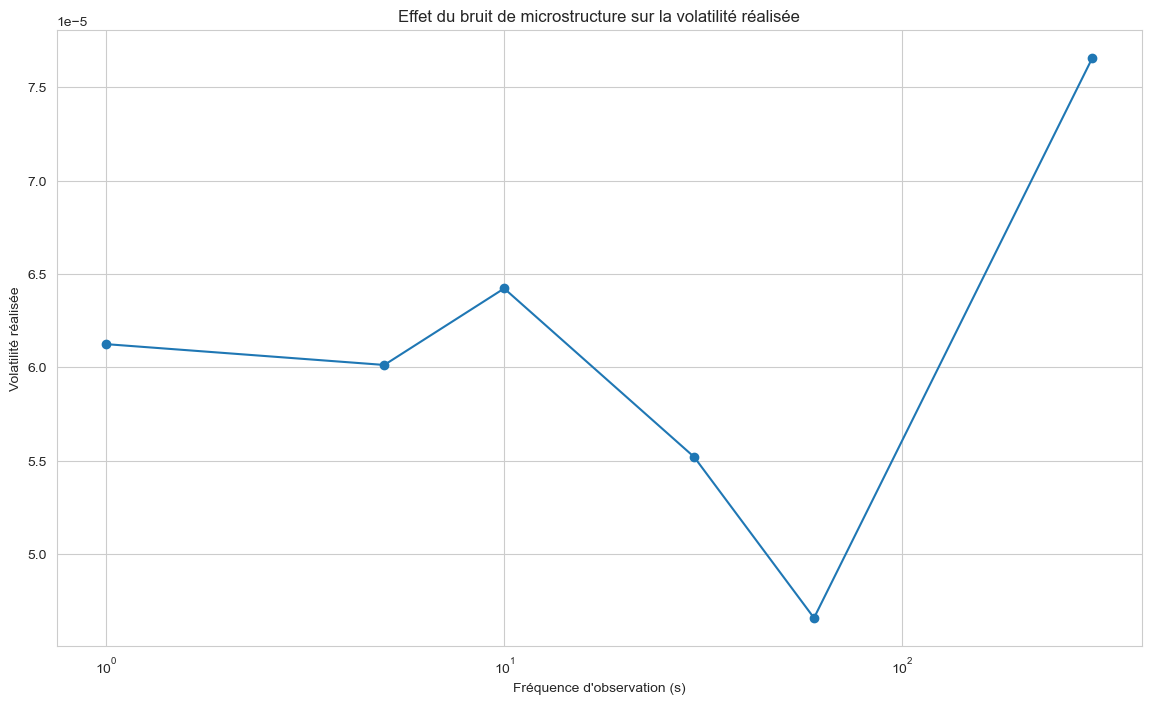

In [149]:
vols = []
for freq in [1, 5, 10, 30, 60, 300]:
    res = realized_volatility_suite(df_OB['MidPrice'], freq_seconds=freq)
    vols.append(res['rv'])
plt.plot([1, 5, 10, 30, 60, 300], vols, marker='o')
plt.xscale('log')
plt.xlabel("Fréquence d'observation (s)")
plt.ylabel("Volatilité réalisée")
plt.title("Effet du bruit de microstructure sur la volatilité réalisée")
plt.grid(True)
plt.show()

In [150]:
def estimate_noise_ratio(rv_dict, ref_freq=60):
    """
    Estime le bruit relatif de microstructure par rapport à une fréquence de référence.
    
    Args:
        rv_dict (dict): {freq: RV} — volatilités réalisées par fréquence
        ref_freq (int): fréquence de référence (en secondes)
    
    Returns:
        dict: {freq: ratio_de_bruit_relatif}
    """
    ref_rv = rv_dict[ref_freq]
    return {
        freq: (rv - ref_rv) / ref_rv
        for freq, rv in rv_dict.items()
        if freq != ref_freq
    }

# Exemple avec tes valeurs
rv_values = {1: 6.124e-05, 5: 6.013e-05, 30: 5.519e-05, 60: 4.657e-05, 300: 7.658e-05}
noise_ratios = estimate_noise_ratio(rv_values, ref_freq=60)

for f, r in noise_ratios.items():
    print(f"{f:>3d}s : bruit relatif = {r*100:.2f}%")


  1s : bruit relatif = 31.50%
  5s : bruit relatif = 29.12%
 30s : bruit relatif = 18.51%
300s : bruit relatif = 64.44%


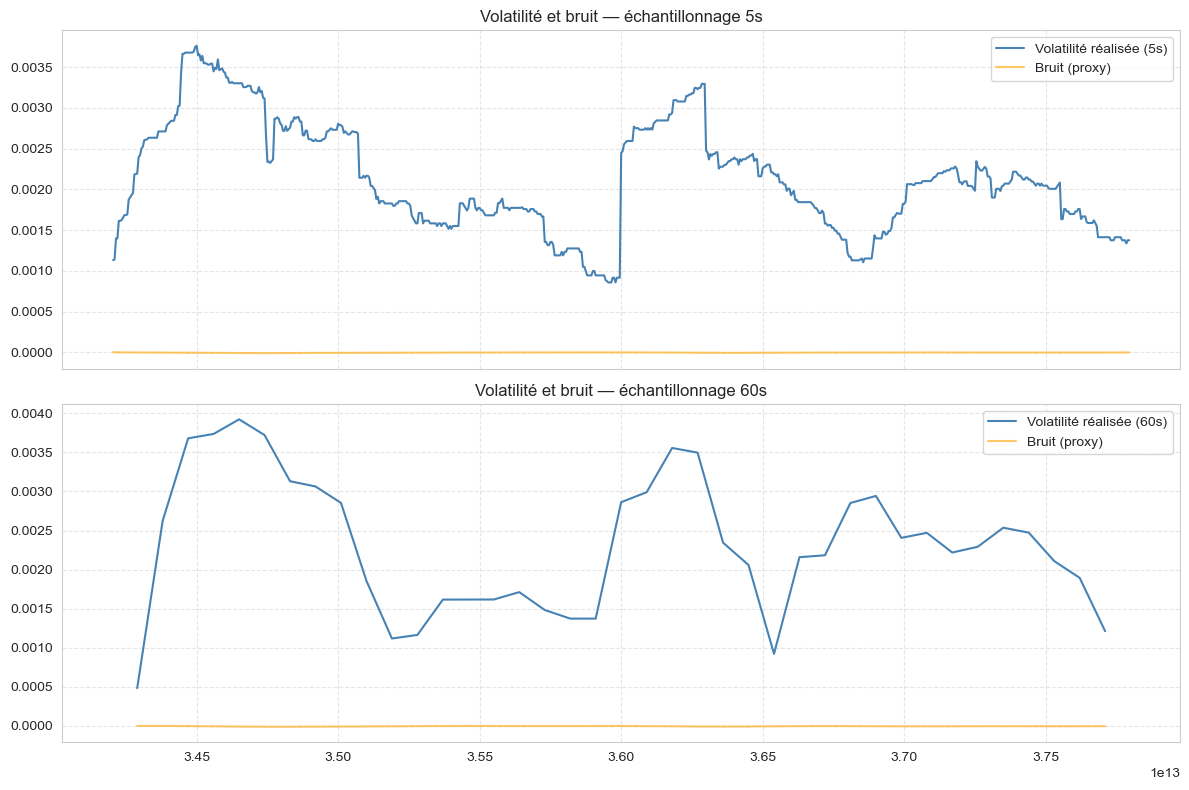

In [151]:
def realized_vol(prices, freq_seconds, window='5min'):
    """
    Calcule la volatilité réalisée glissante à une fréquence donnée.
    """
    # On échantillonne les prix
    prices_resampled = prices.resample(f'{freq_seconds}S').last().dropna()
    
    # Rendements log
    returns = np.log(prices_resampled / prices_resampled.shift(1)).dropna()
    
    # Volatilité réalisée glissante
    rv = returns.rolling(window=window).apply(lambda x: np.sqrt(np.sum(x**2)))
    
    # Proxy de bruit : écart entre rendement instantané² et moyenne mobile
    noise = (returns**2).rolling(window=window).mean() - (rv**2).rolling(window=window).mean()
    
    return returns, rv, noise

# === Exemple d'utilisation ===
returns_5s, rv_5s, noise_5s = realized_vol(df_OB['MidPrice'], freq_seconds=5)
returns_60s, rv_60s, noise_60s = realized_vol(df_OB['MidPrice'], freq_seconds=90)

# === Tracés ===
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(rv_5s.index, rv_5s, label='Volatilité réalisée (5s)', color='steelblue')
axs[0].plot(noise_5s.index, noise_5s, label='Bruit (proxy)', color='orange', alpha=0.6)
axs[0].set_title('Volatilité et bruit — échantillonnage 5s')
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.5)

axs[1].plot(rv_60s.index, rv_60s, label='Volatilité réalisée (60s)', color='steelblue')
axs[1].plot(noise_60s.index, noise_60s, label='Bruit (proxy)', color='orange', alpha=0.6)
axs[1].set_title('Volatilité et bruit — échantillonnage 60s')
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Metrics 5s: {'mean': 4.919380190612084e-10, 'std': 2.8192362995825627e-07, 'mse': 7.948117513185439e-14, 'frac_positive': 0.2712100139082058, 'mean_positive': 2.0412297748099547e-07, 'relative_positive_energy': 0.6659158980008433}
Metrics 60s: {'mean': 8.32722450366178e-09, 'std': 1.085648898335315e-06, 'mse': 1.1787028731246178e-12, 'frac_positive': 0.3559322033898305, 'mean_positive': 1.0660111859299275e-06, 'relative_positive_energy': 0.48585823571568226}


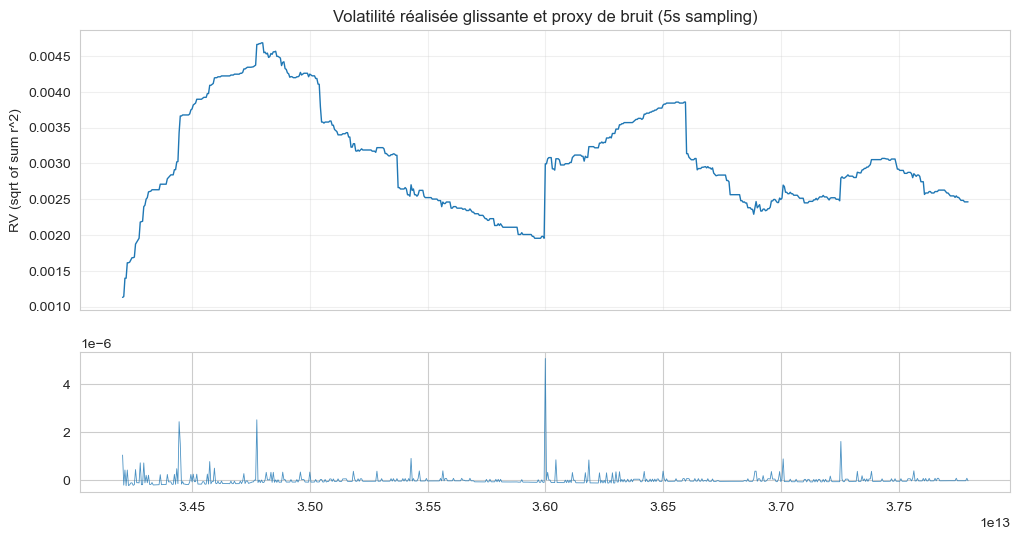

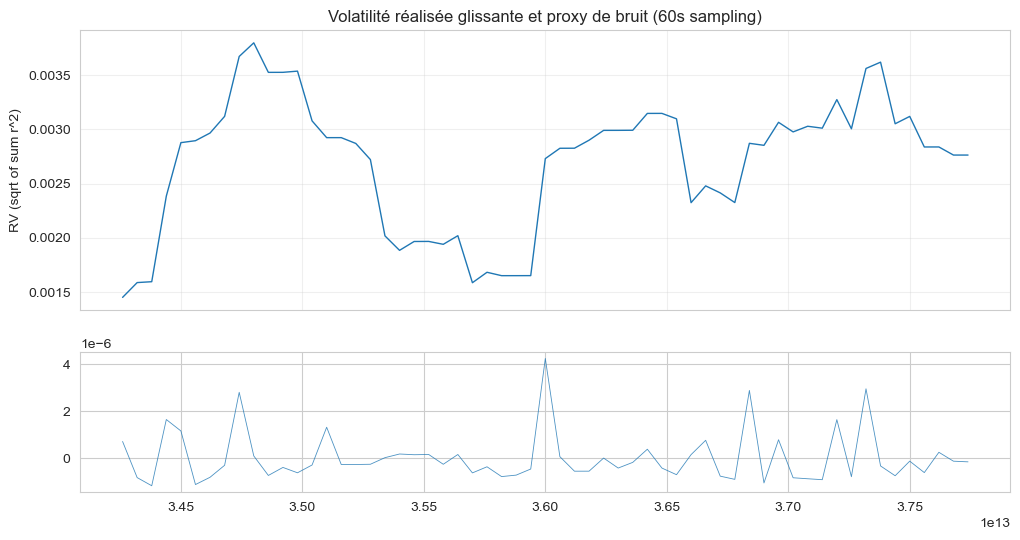

In [152]:
def resample_log_returns(price_series, freq_seconds):
    """Resample prices to freq_seconds and return log-returns (Timedelta/DatetimeIndex required)."""
    rule = f'{int(freq_seconds)}S'
    p = price_series.resample(rule).last().dropna()
    r = np.log(p / p.shift(1)).dropna()
    return r

def noise_proxy_local(r_series, window='5min', method='rolling', center=True):
    """
    Calcule le proxy de bruit local :
      noise_t = r_t^2 - local_expectation(r^2)
    Params:
      - r_series: Series de rendements indexée en temps
      - window: fenêtre temporelle (ex: '5min') ou nombre d'observations (int)
      - method: 'rolling' (moyenne mobile centrée si center=True) ou 'ewm' (exponentially weighted mean)
      - center: pour rolling -> centre la fenêtre
    Retour:
      - noise: Series (mêmes index que r_series)
      - r2_loc: la valeur estimée de E[r^2|t] (Series)
    """
    r2 = (r_series ** 2)
    if method == 'rolling':
        # si window est int -> window en observations; sinon on passe une string temporaire '5min' -> time-based rolling
        if isinstance(window, int):
            r2_loc = r2.rolling(window=window, center=center, min_periods=1).mean()
        else:
            # time-based rolling; requires Datetime/TimedeltaIndex; use .rolling(window) directly
            r2_loc = r2.rolling(window=window, center=center, min_periods=1).mean()
    elif method == 'ewm':
        # alpha chosen to roughly match window length: alpha = 2/(span+1)
        # if window is string we approximate span in seconds (only if string endswith 's'/'min'/'h')
        if isinstance(window, int):
            span = window
        else:
            # parse basic time strings 'Xs', 'Xm', 'Xh'
            s = str(window)
            if s.endswith('s'):
                span = int(s[:-1])
            elif s.endswith('min'):
                span = int(s[:-3]) * 60
            elif s.endswith('h'):
                span = int(s[:-1]) * 3600
            else:
                span = 60
        alpha = 2 / (span + 1)
        r2_loc = r2.ewm(alpha=alpha, adjust=False).mean()
    else:
        raise ValueError("method must be 'rolling' or 'ewm'")

    noise = r2 - r2_loc
    return noise, r2_loc

def noise_metrics(noise_series, r2_loc=None):
    """
    Retourne métriques sur la série de bruit :
      - mean, std, mse (mean of squared noise), fraction_positive, mean_positive
      - relative_energy = sum(positive_noise) / sum(r2_loc)  (si r2_loc fourni)
    """
    arr = noise_series.dropna().values
    mean_n = float(np.mean(arr))
    std_n = float(np.std(arr))
    mse = float(np.mean(arr**2))
    pos = arr[arr > 0]
    frac_pos = float(len(pos) / len(arr)) if len(arr) > 0 else np.nan
    mean_pos = float(np.mean(pos)) if len(pos) > 0 else 0.0
    rel_energy = None
    if r2_loc is not None:
        denom = float(r2_loc.dropna().sum())
        if denom > 0:
            rel_energy = float(np.sum(np.maximum(arr, 0.0)) / denom)
    return {
        'mean': mean_n,
        'std': std_n,
        'mse': mse,
        'frac_positive': frac_pos,
        'mean_positive': mean_pos,
        'relative_positive_energy': rel_energy
    }

def plot_vol_and_noise(price_series, freq_seconds, window='5min', method='rolling', figsize=(12,6), title_suffix=''):
    """
    Trace la volatilité réalisée glissante (sqrt(sum r^2) sur window) vs proxy de bruit (rolling mean of r^2 difference).
    """
    r = resample_log_returns(price_series, freq_seconds)
    noise, r2_loc = noise_proxy_local(r, window=window, method=method)
    # realized vol (RMS) on same local window (time-based)
    # on calcule sqrt(sum r^2) sur la fenêtre -> pour rolling time-based on multiplie par sqrt of count? we'll do sqrt of rolling sum
    if isinstance(window, int):
        rv = r.rolling(window=window, min_periods=1, center=False).apply(lambda x: np.sqrt(np.sum(x**2)))
    else:
        rv = r.rolling(window=window, min_periods=1, center=False).apply(lambda x: np.sqrt(np.sum(x**2)))
    # plot
    fig, ax = plt.subplots(2,1, figsize=figsize, sharex=True, gridspec_kw={'height_ratios':[2,1]})
    ax0, ax1 = ax
    ax0.plot(rv.index, rv, label=f'RV (window={window}, freq={freq_seconds}s)', linewidth=1)
    ax0.set_title(f'Volatilité réalisée glissante et proxy de bruit {title_suffix}')
    ax0.set_ylabel('RV (sqrt of sum r^2)')
    ax0.grid(True, alpha=0.3)

    # noise: plot raw, and positive part highlighted
    ax1.plot(noise.index, noise, label='Noise proxy (r^2 - local mean)', linewidth=0.6, alpha=0.8)

    # metrics
    metrics = noise_metrics(noise, r2_loc=r2_loc)
    return {'noise_series': noise, 'r2_loc': r2_loc, 'rv': rv, 'metrics': metrics}

# === Exemples d'utilisation pour 5s et 60s ===
res_5s = plot_vol_and_noise(df_OB['MidPrice'], freq_seconds=5, window='10min', method='rolling', title_suffix='(5s sampling)')
print("Metrics 5s:", res_5s['metrics'])

res_60s = plot_vol_and_noise(df_OB['MidPrice'], freq_seconds=60, window='10min', method='rolling', title_suffix='(60s sampling)')
print("Metrics 60s:", res_60s['metrics'])

# VaR computation and plot

In [ ]:
V = 1_000_000
alpha = 0.05
z_95 = -norm.ppf(alpha)


# Realized volatility (sqrt of variance)
sigma_5s = np.sqrt(rv_5s)
sigma_60s = np.sqrt(rv_60s)

# MLE Estimator for VaR 95%
VaR_5s = V * z_95 * sigma_5s
VaR_60s = V * z_95 * sigma_60s

print("VaR 95% using 5s vol estimator:", VaR_5s)
print("VaR 95% using 60s vol estimator:", VaR_60s)
print("Difference in VaR:", VaR_60s - VaR_5s)

VaR 95% using 5s vol estimator: Time
0 days 09:30:05.013994120    55275.540396
0 days 09:30:10.013994120    55555.694514
0 days 09:30:15.013994120    61482.382883
0 days 09:30:20.013994120    61482.382883
0 days 09:30:25.013994120    66060.411889
                                 ...     
0 days 10:29:35.013994120    60979.649939
0 days 10:29:40.013994120    60979.649939
0 days 10:29:45.013994120    60115.107562
0 days 10:29:50.013994120    60981.296695
0 days 10:29:55.013994120    60981.296695
Freq: 5s, Name: MidPrice, Length: 719, dtype: float64
VaR 95% using 60s vol estimator: Time
0 days 09:31:30.013994120     36154.267974
0 days 09:33:00.013994120     84261.703534
0 days 09:34:30.013994120     99777.355870
0 days 09:36:00.013994120    100533.313205
0 days 09:37:30.013994120    103015.181437
0 days 09:39:00.013994120    100332.174594
0 days 09:40:30.013994120     92031.541789
0 days 09:42:00.013994120     91041.323197
0 days 09:43:30.013994120     87854.500544
0 days 09:45:00.013994

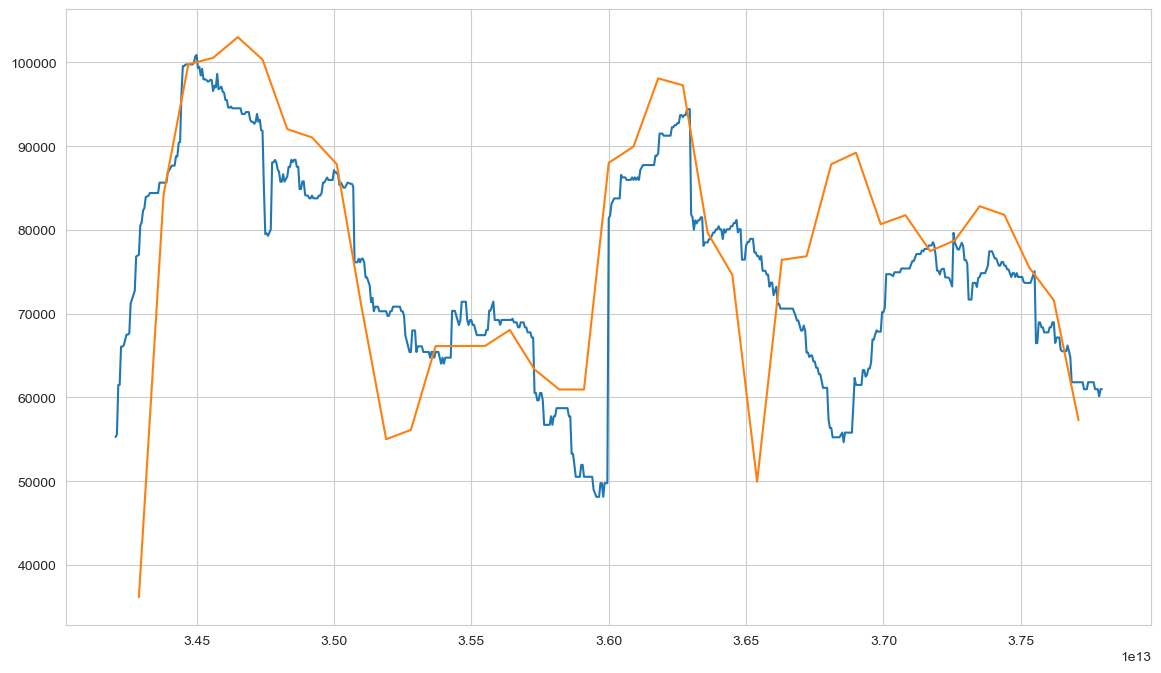

In [154]:
plt.plot(VaR_5s)
plt.plot(VaR_60s)
plt.show()

In [155]:
# Expected Shortfall 95%
ES_5s = V * sigma_5s * norm.pdf(z_95) / (1 - alpha)
ES_60s = V * sigma_60s * norm.pdf(z_95) / (1 - alpha)

print("ES 95% (5s vol):", ES_5s)
print("ES 95% (60s vol):", ES_60s)

ES 95% (5s vol): Time
0 days 09:30:05.013994120    3648.303035
0 days 09:30:10.013994120    3666.793802
0 days 09:30:15.013994120    4057.967819
0 days 09:30:20.013994120    4057.967819
0 days 09:30:25.013994120    4360.127454
                                ...     
0 days 10:29:35.013994120    4024.786377
0 days 10:29:40.013994120    4024.786377
0 days 10:29:45.013994120    3967.724744
0 days 10:29:50.013994120    4024.895066
0 days 10:29:55.013994120    4024.895066
Freq: 5s, Name: MidPrice, Length: 719, dtype: float64
ES 95% (60s vol): Time
0 days 09:31:30.013994120    2386.258454
0 days 09:33:00.013994120    5561.451350
0 days 09:34:30.013994120    6585.517349
0 days 09:36:00.013994120    6635.412139
0 days 09:37:30.013994120    6799.220712
0 days 09:39:00.013994120    6622.136563
0 days 09:40:30.013994120    6074.277173
0 days 09:42:00.013994120    6008.920643
0 days 09:43:30.013994120    5798.583581
0 days 09:45:00.013994120    4676.532043
0 days 09:46:30.013994120    3630.375011

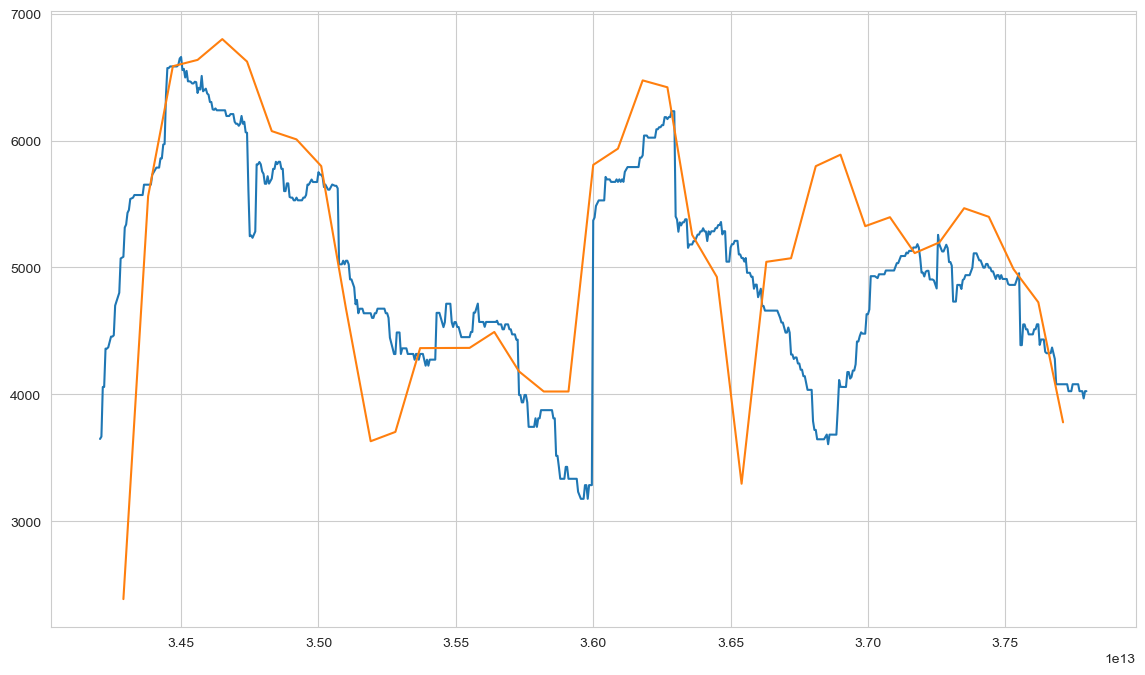

In [173]:
plt.plot(ES_5s)
plt.plot(ES_60s)
plt.show()